# Asteroid use case notebook

ALeRCE starter notebook for asteroid science.

**WARNING**: This notebook will be replaced by a version using the new database, API and client.

You will need to install psycopg2 and the alerce api

In this notebook you will connect to the ALeRCE database, and download asteroid candidates from the last 10 days

You will plot their spatial distribution using datashader and bokeh

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from datetime import datetime
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

In [2]:
from matplotlib.cm import viridis

ALeRCE client

In [3]:
#!pip install alerce
from alerce.api import AlerceAPI
client = AlerceAPI()

Use pyephem https://pypi.org/project/pyephem/

In [4]:
#!pip install pyephem
import ephem

Install psycopg2 https://github.com/psycopg/psycopg2

In [5]:
#!pip install psycopg2-binary
import psycopg2

### Get credentials (in github repository)

In [6]:
import json
credentials_file = "../alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

### Connect to DB

In [7]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

### Show all the available tables

In [8]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

tablename
9                    asassn
18                    class
10                crtsnorth
12                crtssouth
4                detections
23  early_classification_v2
16                 features
22              features_v2
2               features_v3
24      ingestion_timestamp
1                insert_tmp
25     late_class_timestamp
5     late_probabilities_v2
0     late_probabilities_v3
14                   linear
19                   magref
20           non_detections
3                   objects
15            probabilities
11     stamp_classification
7                 tax_class
6                  taxonomy
8                temp_probs
21               temp_table
17                      tns
13                   xmatch

### For each table, show column names and column types

In [9]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

table                     column_name  \
0                     asassn                    ASAS-SN Name   
1                     asassn                     Other Names   
2                     asassn                            LCID   
3                     asassn                              ra   
4                     asassn                             dec   
5                     asassn                       Mean VMag   
6                     asassn                       Amplitude   
7                     asassn                          Period   
8                     asassn                            Type   
9                     asassn                             Url   
10                    asassn                       Reference   
11                    asassn                            Dist   
12                    asassn                        Parallax   
13                    asassn                  Parallax Error   
14                    asassn                            Gmag   
15                    asassn                           Bpmag   
16                    asassn                           Rpmag   
17                    asassn                            Jmag   
18                    asassn                            Hmag   
19                    asassn                            Kmag   
20                    asassn                           W1mag   
21                    asassn                           W2mag   
22                    asassn                           W3mag   
23                    asassn                           W4mag   
24                    asassn                           BP-RR   
25                    asassn                             J-K   
26                    asassn                           W1-W2   
27                    asassn                           W3-W4   
28                    asassn                  Sllk Statistic   
29                    asassn             RF Regression Score   
30                    asassn      Classification Probability   
31                    asassn                     Epoch (HJD)   
0                      class                              id   
1                      class                            name   
0                  crtsnorth             Catalina_Surveys_ID   
1                  crtsnorth                    Numerical_ID   
2                  crtsnorth                         V_(mag)   
3                  crtsnorth                   Period_(days)   
4                  crtsnorth                       Amplitude   
5                  crtsnorth                      Number_Obs   
6                  crtsnorth                        Var_Type   
7                  crtsnorth                              ra   
8                  crtsnorth                             dec   
0                  crtssouth                          SSS_ID   
1                  crtssouth                    Numerical_ID   
2                  crtssouth                              ra   
3                  crtssouth                             dec   
4                  crtssouth                          Period   
5                  crtssouth                           V_CSS   
6                  crtssouth                            Npts   
7                  crtssouth                           V_amp   
8                  crtssouth                            Type   
0                 detections                             oid   
1                 detections                          candid   
2                 detections                             mjd   
3                 detections                             fid   
4                 detections                      diffmaglim   
5                 detections                          magpsf   
6                 detections                           magap   
7                 detections                        sigmapsf   
8                 detections                        sigmagap   
9                 detections                           

### Query class numbers

In [10]:
query = "select * from class"
classes = pd.read_sql_query(query, conn)
classmapper = dict(zip(classes.name.tolist(), classes.id.tolist()))
classmapper

{'Other': 0,
 'Ceph': 1,
 'LPV': 4,
 'RRL': 5,
 'EB': 3,
 'SNe': 6,
 'DSCT': 2,
 'Blazar': 8,
 'CV/Nova': 9,
 'SLSN': 14,
 'AGN': 18,
 'SN': 19,
 'Variable Star': 20,
 'Asteroid': 21,
 'Bogus': 22,
 'SNIa': 10,
 'SNIbc': 11,
 'SNII': 12,
 'SNIIn': 13,
 'EBSD/D': 15,
 'EBC': 16,
 'Periodic-Other': 17,
 'AGN-I': 7,
 'RS-CVn': 23,
 'QSO-I': 24}

### Query objects which appeared during the last 10 days, which have at most one detection, and which are classified as asteroids by the early classifier with a probability greater than 0.95

Please contact us for larger queries. This query of only 10 days takes about 5 seconds.

In [11]:
mjd_last = Time(datetime.utcnow(), scale='utc').mjd - 30

query='''
select objects.oid, objects.meanra, objects.meandec, objects.firstmjd,
objects.nobs, objects.classearly, objects.pclassearly

from objects

where objects.firstMJD > %s  and objects.nobs=1
and objects.classearly=%i and objects.pclassearly>0.95
''' % (mjd_last, classmapper["Asteroid"])

ast = pd.read_sql_query(query, conn)
ast.set_index('oid', inplace=True)
ast.head()

meanra    meandec      firstmjd  nobs  classearly  \
oid                                                                   
ZTF20ablhmag  214.610896  31.098627  59043.239977     1          21   
ZTF20ablhqnr  230.423939 -18.452029  59043.251493     1          21   
ZTF20ablhref  227.055852 -15.593288  59043.251493     1          21   
ZTF20ablhrir  239.469105 -23.576443  59043.250995     1          21   
ZTF20ablhrhf  228.738393 -19.209015  59043.251493     1          21   

              pclassearly  
oid                        
ZTF20ablhmag          1.0  
ZTF20ablhqnr          1.0  
ZTF20ablhref          1.0  
ZTF20ablhrir          1.0  
ZTF20ablhrhf          1.0

In [12]:
ast.shape

(503404, 6)

# Plot distribution in the sky using datashader

In [13]:
import datashader as ds
import datashader.transfer_functions as tf
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage

In [14]:
bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(0,360), y_range=(-90,90), plot_width=800, plot_height=500)

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(ast, 'meanra', 'meandec', ds.count())
    img = tf.shade(agg, cmap=viridis)
    return tf.spread(img)

InteractiveImage(p, image_callback)

Loading BokehJS ...

/home/fforster/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


# Move to ecliptic coordinates

In [15]:
ecl = ast.apply(lambda row: ephem.Ecliptic(ephem.Equatorial('%s' % (row.meanra / 15.), '%s' % row.meandec, epoch=ephem.J2000)), axis=1)

In [16]:
ast["ecl_lat"] = ecl.apply(lambda row: np.rad2deg(row.lat))
ast["ecl_long"] = ecl.apply(lambda row: np.rad2deg(row.long))

In [17]:
ast["ecl_lat"] = ecl.apply(lambda row: np.rad2deg(row.lat))
ast["ecl_long"] = ecl.apply(lambda row: np.rad2deg(row.long))

In [18]:
bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(0,360), y_range=(-90,90), plot_width=800, plot_height=500)

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(ast, 'ecl_long', 'ecl_lat', ds.count())
    img = tf.shade(agg, cmap=viridis)
    return tf.spread(img)

InteractiveImage(p, image_callback)

Loading BokehJS ...

/home/fforster/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Note that most selected objects are around the ecliptic. Also note that you can see individual tracks!

# Plot histogram of ecliptic latitudes

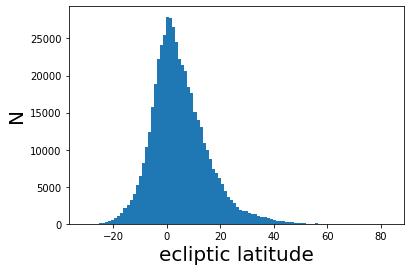

In [19]:
fig, ax = plt.subplots()
ax.hist(ast.ecl_lat, bins=100);
ax.set_xlabel("ecliptic latitude", fontsize=20)
ax.set_ylabel("N", fontsize=20)
plt.savefig("asteroid_ecl_lat.png")

# Plot the stamps of 10 random candidates

In [20]:
for oid in np.random.choice(ast.index, 10):
    client.plot_stamp(oid)